# The color atlas (from optimal color solid)

In [1]:
from colormath.color_conversions import convert_color
from colormath.color_objects import sRGBColor, XYZColor
from mpl_toolkits.mplot3d import axes3d
from numpy import cos, sin
from numpy import pi
from scipy.optimize import minimize
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as intp
from scipy.optimize import minimize
%matplotlib inline

# 1. Get color matching functions (from the CIE study)

* These define the "tangent space" from the black point (and inverted, from the white point).
* We draw rays from each point through the color matching functions.
* These will draw a "double cone" and intersect at the "characteristic colors".

In [2]:
# this is in XYZ space
MF = np.genfromtxt("CMF_5nm.csv", delimiter=',')
cmf = MF[:, 1:4]

# sum of each component (we use when normalizing)
NORM = sum(cmf)

# achromatic beam -- using uniform for now -- get the whitepoint from this value
# the achromatic beam "scales" the CMF function in XYZ space
abeam = np.ones(cmf.shape[0])
wtpt = cmf.T@abeam

### Add 'purple' colors and make a uniform CMF

In [3]:
ucmf = [c/np.linalg.norm(c) for c in cmf]

# add mixtures of extremal points (red and blue)
# making convex combinations of the endpoints of the CMF to "close" the CMF curve

# Note: The spline has to close, so this has to go from 0 to 1!!
NUMBER_MIXTURE_PTS = 30
coeffs = np.linspace(0, 1, NUMBER_MIXTURE_PTS)
c1 = ucmf[-1]
c0 = ucmf[0]
mixture = []
for c in coeffs:
    mix = c*c0 + (1-c)*c1
    mixture.append(mix/np.linalg.norm(mix))
units = np.concatenate((ucmf, mixture))

### Make continuous "spline" from CMF functions

In [4]:
I = np.linspace(0, 2*np.pi, len(units))
x_spline = intp.make_interp_spline(I, units[:, 0])
y_spline = intp.make_interp_spline(I, units[:, 1])
z_spline = intp.make_interp_spline(I, units[:, 2])

In [5]:
num_upsampled_pts = int(1e6)
vec = lambda s: np.array([x_spline(s), y_spline(s), z_spline(s)])
input_pts = np.linspace(0, 2*np.pi, num_upsampled_pts + 1)
spline_pts = vec(input_pts)

# 2. Rotate the frame to put whitepoint on an axis

In [6]:
# http://scipp.ucsc.edu/~haber/ph216/rotation_12.pdf
def get_rot_matrix(n, t):
    n1,n2,n3 = n[0],n[1],n[2]
    return np.array([
        [cos(t) + n1*n1 * (1 - cos(t)), n1*n2*(1 - cos(t)) - n3*sin(t), n1*n3*(1 - cos(t)) + n2*sin(t)],
        [n1*n2*(1 - cos(t)) + n3*sin(t), cos(t) + n2*n2*(1 - cos(t)), n2*n3*(1 - cos(t)) - n1*sin(t)],
        [n1*n3*(1 - cos(t)) - n2*sin(t), n2*n3*(1 - cos(t)) + n1*sin(t), cos(t) + n3*n3*(1 - cos(t))],
    ])

In [7]:
# move [x,y,z] to [0,r,0]
uwtpt = wtpt/np.linalg.norm(wtpt)
cross = np.cross(uwtpt, [0,1,0])
theta = np.arccos(np.dot(uwtpt, [0,1,0]))
assert np.allclose(uwtpt, get_rot_matrix(cross/np.linalg.norm(cross), -theta) @ [0,1,0])
assert np.allclose([0,1,0], get_rot_matrix(cross/np.linalg.norm(cross), theta) @ uwtpt)

### Rotate to the $(\rho, white, \theta)$ frame (using cylindrical coordinates)

In [8]:
rot = get_rot_matrix(cross/np.linalg.norm(cross), theta)
rotated_spline_pts = rot @ spline_pts # TODO rename to "cmf_points" or something
wt_mag = (rot @ wtpt)[1]

In [9]:
# some extra magic to make sure we get the whole angle from [0,2pi)
# TODO -- I should de"clever" this..

def get_theta(v):
    return np.sign(v[2])*np.arccos(v[0] / (v[0]**2 + v[2]**2)**0.5) \
     - np.sign(v[2]) * np.pi + np.pi

In [10]:
thetas = get_theta(rotated_spline_pts)

### Ensure the CMF function is monotonic (up to period) in $\theta$

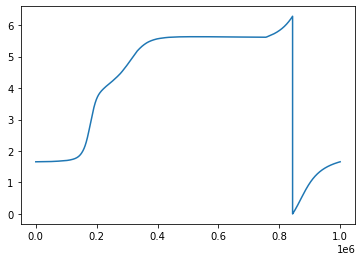

In [11]:
plt.plot(thetas)

# 3. Cut planes in the optimal color solid

In [12]:
# makes a "on/off" optimal function with a different value from x0 to xf
def bump(I, x0, xf):
    out = np.zeros(len(I))
    if x0 < xf:
        out[x0:xf] = 1
    elif x0 > xf:
        out[x0:] = 1
        out[0:xf] = 1
    return out

# returns the Optimal color in XYZ space with transition wavelengths wl1 and wl2
def Optimal(wl1, wl2, cmf, abeam, normalized=False):
    """
    Optimal windowing function with wrapping
    """
    abeam_matrix = np.diag(abeam)
    X =  np.dot(abeam_matrix@cmf[:,0], bump(cmf, wl1, wl2))
    Y =  np.dot(abeam_matrix@cmf[:,1], bump(cmf, wl1, wl2))
    Z =  np.dot(abeam_matrix@cmf[:,2], bump(cmf, wl1, wl2))
    XYZ = [X, Y, Z]
    if normalized:
        return (XYZ[0]/NORM[0], XYZ[1]/NORM[1], XYZ[2]/NORM[2])
    else:
        return (XYZ[0], XYZ[1], XYZ[2])

### Create the optimal color "grid"

In [13]:
# number of CMF points
L = cmf.shape[0]

# all optimal colors we can calculate
optimal_color_grid = []
for i in range(0, L, 1):
    v = []
    for j in range(0, L, 1):
        O = Optimal(i, (i+j)%L, cmf, abeam)
        v.append(O)
    optimal_color_grid.append(v)
optimal_color_grid = np.array(optimal_color_grid)

In [14]:
rotated_color_grid = np.einsum('ij,abj->abi' ,rot, optimal_color_grid)

In [15]:
def clip2rgb(xyz):
    XYZ = XYZColor(xyz[0], xyz[1], xyz[2])
    crgb = convert_color(XYZ, sRGBColor)
    r = crgb.rgb_r
    g = crgb.rgb_g
    b = crgb.rgb_b
    r = r if r > 0 else 0
    g = g if g > 0 else 0
    b = b if b > 0 else 0
    r = r if r < 1 else 1
    g = g if g < 1 else 1
    b = b if b < 1 else 1
    return [r, g, b]

### Make spline for optimal color grid

In [16]:
from scipy.interpolate import RectBivariateSpline as Rspl

In [17]:
I = np.linspace(0, 1, 89)
spx = Rspl(I, I, rotated_color_grid.T[0])
spy = Rspl(I, I, rotated_color_grid.T[1])
spz = Rspl(I, I, rotated_color_grid.T[2])

def vec_grid(s):
    return np.array([spx(*s)[0][0], spy(*s)[0][0], spz(*s)[0][0]])

In [18]:
v_spx = np.vectorize(spx)
v_spy = np.vectorize(spy)
v_spz = np.vectorize(spz)

def vectorized_vec_grid(s):
    return np.array([v_spx(*s), v_spy(*s), v_spz(*s)])

### Guess at best point for spline

In [19]:
xy = np.mgrid[0:1:.001, 0:1:.001]
optimal_pts = vectorized_vec_grid(xy)
optimal_thetas = get_theta(optimal_pts)
optimal_ys = optimal_pts[1]

In [20]:
def closest_pt(theta, y):
    twopi = 2*pi
    diff = np.abs((optimal_thetas + twopi - theta) % twopi)**2 / twopi**2 + np.abs(optimal_ys - y)**2/wt_mag**2
    idx = np.unravel_index(np.argmin(diff), optimal_thetas.shape)
    return idx

v_closest_pt = np.vectorize(closest_pt)

### Pick closest point to given y and theta

In [21]:
def dist(s, theta, y):
    # goal is to find a point on the optimal color solid
    # with theta given and y on achromatic axis
    # this is the distance
    pt = vec_grid(s)
    theta_pt = get_theta(pt)
    y_pt = pt[1]
    out = abs( (theta - theta_pt) )**2 / (2*pi)**2   +   abs(y - y_pt)**2 / wt_mag**2
    return out

In [22]:
NUM_YS = 20
ys = np.linspace(0 + 1, (rot@wtpt)[1] - 1, NUM_YS)
NUM_THETAS = 32
thetas = np.linspace(0, 2*pi, NUM_THETAS + 1)[:-1]

In [23]:
%%time
outputs = np.zeros((len(ys), len(thetas), 3))
for yidx, y in enumerate(ys):
    print(yidx)
    c_pts = v_closest_pt(thetas,y)
    starts = xy[:,c_pts[0],c_pts[1]]
    for tidx, theta in enumerate(thetas):
        minim = minimize(fun=dist, x0=starts[:,tidx], bounds=[(0, 1),(0,1)], args=(theta,y))
        outputs[yidx, tidx] = vec_grid(minim.x)
#         print(dist(starts[:,tidx], theta, y), dist(minim.x, theta, y))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
CPU times: user 24 s, sys: 61.4 ms, total: 24 s
Wall time: 24.1 s


# 4. Get semichromes

### Fit Chromaticity Curve to a B-spline in parameterized xy coordinants

In [24]:
def XYZ2xyY(X, Y, Z):
    r = X + Y + Z
    x = X/r
    y = Y/r
    return [x, y, Y]

def g_euc(r1, r2):
    g = 0
    for i, _ in enumerate(r1):
        g+= (r1[i] - r2[i])**2
    return np.sqrt(g)

In [25]:
xvec = []
yvec = []
for c in cmf:
    [x, y, _] = XYZ2xyY(c[0], c[1], c[2])
    xvec.append(x)
    yvec.append(y)

s = np.linspace(0, 1, len(cmf)) # spline coordinant
spline = intp.make_interp_spline(s, np.c_[xvec, yvec])

def s2wl(s, spline, cmf):
    """Convert s-coordinant to a wavelength index
        by matching closest point in cmf
    """
    xyset = [XYZ2xyY(c[0], c[1], c[2])[0:2] for c in cmf]
    distset = [g_euc(spline(s), p) for p in xyset]
    return np.argmin(distset)

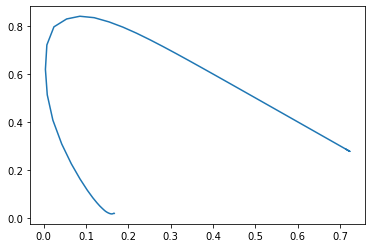

In [26]:
s = np.linspace(0, 1, 100)
plt.plot(spline(s)[:,0], spline(s)[:,1])

### Define the white point and complementary function

In [27]:
wtXYZ = np.dot(abeam, cmf)
wtxy = XYZ2xyY(wtXYZ[0], wtXYZ[1], wtXYZ[2])[0:2]

In [28]:
def line(x, m, b):
    """Function for a line"""
    return m*x+b

def g_line2locus(s, xy, wtpt, spline): 
    """distance between line xy-wtpt and locus"""
    slope = (wtpt[1] - xy[1])/(wtpt[0] - xy[0])
    b = wtpt[1] - slope*wtpt[0]
    if type(s) == np.ndarray: # correction for minimization use
        s = s[0]
    xy1 = [spline(s)[0], spline(s)[1]]
    xy2 = [spline(s)[0], line(spline(s)[0], slope, b)]
    return g_euc(xy1, xy2) 

def comp0(spline, wtpt):
    """Return complementary spline-coodinant of 0"""
    wlxy = np.array(spline(0))
    wtpt = np.array(wtpt)
    st = minimize(fun=g_line2locus, x0=0.7, bounds=[(0.3, 0.999)], args=(wlxy, wtpt, spline))
    return st

def comp1(spline, wtpt):
    """Return complementary spline-coodinant of 1"""
    wlxy = np.array(spline(1))
    wtpt = np.array(wtpt)
    st = minimize(fun=g_line2locus, x0=0.2, bounds=[(0, 0.3)], args=(wlxy, wtpt, spline))
    return st

def comp(s, spline, wtpt):
    """Return complementary spline-coodinant of s
    careful: if s is a green color, then there may be no complementary wl"""
    c0 = comp0(spline, wtpt).x[0]
    c1 = comp1(spline, wtpt).x[0]
    wlxy = np.array(spline(s))
    wtpt = np.array(wtpt)
    if 0 <= s and s < c1:
        # between lam0 and bar{lam}f
        return minimize(fun=g_line2locus, x0=0.7, bounds=[(c0, 1)], args=(wlxy, wtpt, spline)).x[0]
    elif c1 <= s and s < c0:
        # between bar{lam}f and bar{lam}0
        return 1
    elif c0 <= s and s <=1:
        return minimize(fun=g_line2locus, x0=0.7, bounds=[(0, c1)], args=(wlxy, wtpt, spline)).x[0]

[0.71416994 0.28583006] [0.02795488 0.37135672]


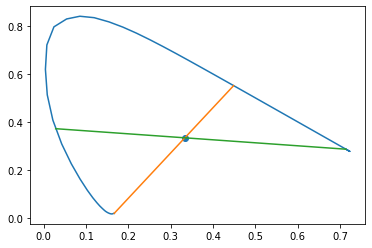

In [29]:
result0 = comp0(spline, wtxy)
result1 = comp1(spline, wtxy)
xy0 = spline(0)
[cxy0] = spline(result0.x)
xy1 = spline(1)
[cxy1] = spline(result1.x)
s = np.linspace(0, 1, 100)
plt.plot(spline(s)[:,0], spline(s)[:,1])
plt.plot((xy0[0], cxy0[0]), (xy0[1], cxy0[1]))
print(xy1, cxy1)
plt.plot((xy1[0], cxy1[0]), (xy1[1], cxy1[1]))
plt.scatter(wtxy[0], wtxy[1])

### Define semichrome map

In [30]:
def semi(s, spline, wtpt, cmf, sign=True):
    c = comp(s, spline, wtpt)
    L = len(cmf)
    piout = np.zeros((L))
    l_i = s2wl(min(s, c), spline, cmf)
    l_f = s2wl(max(s, c), spline, cmf)
    if sign:
        piout[l_i:l_f+1] = 1
    else:
        piout[0:l_i] = 1
        piout[l_f+1::] = 1
        
    return piout

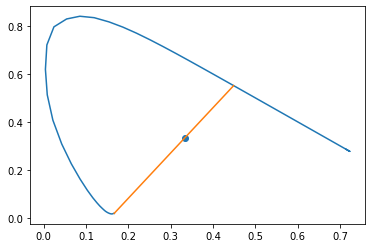

In [31]:
s = np.linspace(0, 1, 100)
plt.plot(spline(s)[:,0], spline(s)[:,1])
plt.scatter(wtxy[0], wtxy[1])
plt.plot((xy0[0], cxy0[0]), (xy0[1], cxy0[1]))

### Get closest semichromes to given theta

In [32]:
%%time
c0 = comp0(spline, wtpt).x[0]
I = list(np.linspace(0, 0.1, 50)) + list(np.linspace(0.1, 0.2, 100)) + list(np.linspace(0.2, c0-0.0001, 400))
semi_thetas = []
semi_cpis = []
for i in I:
    Pip = semi(i, spline, wtxy, cmf)
    cpi = np.dot(Pip, cmf)
    semi_cpis.append(cpi)
    semi_thetas.append(get_theta(rot @ cpi))

    Pim = semi(i, spline, wtxy, cmf, False)
    cpi_gap = np.dot(Pim, cmf)
    semi_cpis.append(cpi_gap)
    semi_thetas.append(get_theta(rot @ cpi_gap))

CPU times: user 42.9 s, sys: 62.2 ms, total: 43 s
Wall time: 42.9 s


In [33]:
semi_cpis = np.array(semi_cpis)
semi_thetas = np.array(semi_thetas)

In [34]:
def get_closest_cpi(theta):
    return semi_cpis[np.argmin(abs(semi_thetas - theta))]

In [35]:
semi_equal_thetas= []

In [36]:
for t in thetas:
    print(t, get_closest_cpi(t))
    semi_equal_thetas.append(get_closest_cpi(t))

0.0 [16.59532094  9.0093332  11.09458252]
0.19634954084936207 [16.91778464  9.07405672 12.94312752]
0.39269908169872414 [16.91778464  9.07405672 12.94312752]
0.5890486225480862 [16.31511164  8.20398321 14.60722785]
0.7853981633974483 [16.56363704  8.28913137 16.12938485]
0.9817477042468103 [16.96630564  8.52504157 18.80843485]
1.1780972450961724 [15.08064784  6.92346657 19.80726847]
1.3744467859455345 [11.75805679  4.84435077 20.56233132]
1.5707963267948966 [ 7.66374874  2.95286767 21.12401324]
1.7671458676442586 [ 3.61769815  2.1295039  22.08221374]
1.9634954084936207 [ 4.308849    6.9758346  22.58879719]
2.1598449493429825 [ 6.5899074  11.89697    22.61232469]
2.356194490192345 [ 7.56790198 13.80794051 19.96210804]
2.552544031041707 [ 7.02722508 13.74862907 17.10427404]
2.748893571891069 [ 6.70451638 13.70704967 15.35599404]
2.945243112740431 [ 6.35626098 13.6567131  13.43851504]
3.141592653589793 [ 6.01441268 13.59927917 11.52007804]
3.3379421944391554 [ 5.69194898 13.53455565  9.67

### Plot semichromes

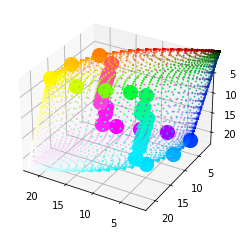

In [37]:
C0 = []
C1 = []
C2 = []
RGB = []
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlim(sum(cmf[:,0]))
ax.set_ylim(sum(cmf[:,1]))
ax.set_zlim(sum(cmf[:,2]))
L = cmf.shape[0]
for i in range(0, L, 1):
    for j in range(0, L, 1):
        O = Optimal(i, (i+j)%L, cmf, abeam)
        C0.append( O[0] )
        C1.append( O[1] )
        C2.append( O[2] )
        RGB.append(clip2rgb(O/sum(cmf)))
ax.scatter(C0, C1, C2, c=RGB, s=1)

for s in semi_equal_thetas:
    rgb = clip2rgb(s/sum(cmf))
    ax.scatter(*s, color=rgb, s=200)

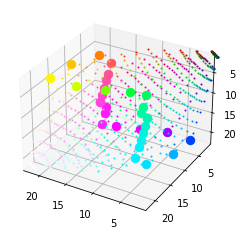

In [38]:
# this plots just the equal theta points
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlim(sum(cmf[:,0]))
ax.set_ylim(sum(cmf[:,1]))
ax.set_zlim(sum(cmf[:,2]))

for o in outputs:
    for t in o:
        rgb = clip2rgb((rot.T @ t)/sum(cmf))
        ax.scatter(*(rot.T @ t), color=rgb, s=1)

for s in semi_equal_thetas:
    rgb = clip2rgb(s/sum(cmf))
    ax.scatter(*s, color=rgb, s=70)

# 5. Get axial divisions

We want to preserve "complementary" colors -- if you are on the opposite side of the sphere, you should get the complementary wavelength.

So given a semichrome at position $\phi = \pi/2 - \gamma$, we can map $f$ so that $0 \to 0$ and $\pi/2-\gamma \to \pi/2$.

But on the flip side, we have a map $f_2$ that $\pi \to \pi$ and $\pi/2 + \gamma \to \pi/2$. And in particular, $f(x) + f_2(\pi-x) = \pi$ that is linearity!

So any map $f$ will fully define $f_2$ for all points.

Let's use a simple map $f(x) = \pi/2 \gamma / (\pi/2 - \gamma) = 1 / (1/\gamma - 2/\pi)$. This is a linear stretch over the angular coordinate.

This makes $f_2(\pi - x) = \pi - f(x) = \pi - 1/(1/\gamma - 2/\pi)$.

Another map idea is to use the arc length on the ellipsoid and divide out the arc length evenly over the sphere range.

### Get gamma at each semichrome

In [39]:
gray = np.array([0,wt_mag/2,0])

In [40]:
rot_semi_equal_thetas = (rot @ np.array(semi_equal_thetas).T).T

In [41]:
def get_gamma(r):
    vec = r - gray
    return np.arcsin(vec[1]/np.linalg.norm(vec))

In [42]:
gammas = []
for r in rot_semi_equal_thetas:
    gammas.append(get_gamma(r))

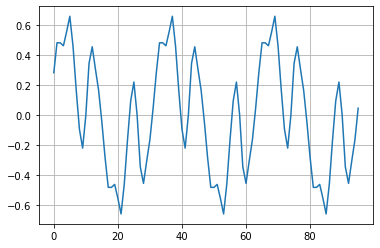

In [43]:
plt.plot(gammas + gammas + gammas)
plt.grid()

### Equally separate angles from 0 to $\pi/2 - \gamma$

In [44]:
NUM_PTS = 8

In [45]:
def get_gamma_big(r):
    vec = r - gray[:,None,None]
    return np.arcsin(vec[1]/np.linalg.norm(vec, axis=0))

def get_gamma(r):
    vec = r - gray
    return np.arcsin(vec[1]/np.linalg.norm(vec))

In [46]:
optimal_angles = pi/2 - get_gamma_big(optimal_pts)

In [47]:
def closest_pt_angle(theta, angle):
    twopi = 2*pi
    diff = np.abs((optimal_thetas + twopi - theta) % twopi)**2 / twopi**2 + np.abs(optimal_angles - angle)**2/pi**2
    idx = np.unravel_index(np.argmin(diff), optimal_thetas.shape)
    return idx

v_closest_pt_angle = np.vectorize(closest_pt_angle)

In [48]:
def dist_angle(s, theta, angle):
    # goal is to find a point on the optimal color solid
    # with theta given and angle above gray
    # this is the distance
    pt = vec_grid(s)
    theta_pt = get_theta(pt)
    angle_pt = pi/2 - get_gamma(pt)
    out = abs( (theta - theta_pt) )**2 / (2*pi)**2   +   abs(angle - angle_pt)**2 / (pi)**2
    return out

In [49]:
%%time
final_outputs = np.zeros((NUM_PTS + 1 + NUM_PTS, len(thetas), 3))
for tidx, theta in enumerate(thetas):
    print(tidx)
    gamma = gammas[tidx]
    angles = np.linspace(0, pi/2 - gamma, NUM_PTS + 2)[1:-1]
    # TODO decide if you want the warm start
    c_pts = v_closest_pt_angle(theta,angles)
    starts = xy[:,c_pts[0],c_pts[1]]
#     print(starts[:,0].shape)
    for aidx, angle in enumerate(angles):
#         print('guess:', dist_angle(starts[:,aidx], theta, angle))
        minim = minimize(fun=dist_angle, x0=starts[:,aidx], bounds=[(0, 1),(0,1)], args=(theta,angle), options={"ftol":1e-8})
        final_outputs[aidx, tidx] = vec_grid(minim.x)
#         print('minim:', dist_angle(minim.x, theta, angle))
    final_outputs[NUM_PTS, tidx] = rot_semi_equal_thetas[tidx]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
CPU times: user 9.6 s, sys: 48.5 ms, total: 9.64 s
Wall time: 9.66 s


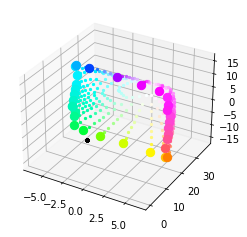

In [50]:
# this plots just the equal theta points
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.set_xlim(sum(cmf[:,0]))
# ax.set_ylim(sum(cmf[:,1]))
# ax.set_zlim(sum(cmf[:,2]))

for o in final_outputs:
    for t in o:
        rgb = clip2rgb((rot.T @ t)/sum(cmf))
        ax.scatter(*(t), color=rgb, s=5)

for s in semi_equal_thetas:
    rgb = clip2rgb(s/sum(cmf))
    ax.scatter(*(rot @s), color=rgb, s=70)

In XYZ coordinates:

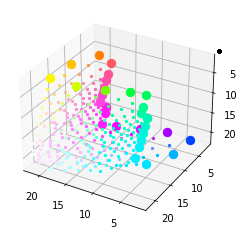

In [51]:
# this plots just the equal theta points
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlim(sum(cmf[:,0]))
ax.set_ylim(sum(cmf[:,1]))
ax.set_zlim(sum(cmf[:,2]))

for o in final_outputs:
    for t in o:
        rgb = clip2rgb((rot.T @ t)/sum(cmf))
        ax.scatter(*(rot.T @ t), color=rgb, s=5)

for s in semi_equal_thetas:
    rgb = clip2rgb(s/sum(cmf))
    ax.scatter(*(s), color=rgb, s=70)

### Reflect to other side

I assume the solid is symmetric! So points above one semichrome match up with points below the complementary semichrome

In [52]:
tidxs = list(range(len(thetas)))
halfway_switched_tidxs = tidxs[int(len(tidxs)/2):] + tidxs[:int(len(tidxs)/2)]

In [53]:
reverse_angles = list(range(NUM_PTS+1, final_outputs.shape[0]))[::-1]

In [54]:
final_outputs[reverse_angles, :, :] = gray - (final_outputs[:NUM_PTS, halfway_switched_tidxs, :] - gray)

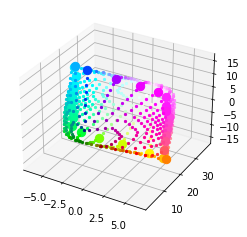

In [55]:
# this plots just the equal theta points
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.set_xlim(sum(cmf[:,0]))
# ax.set_ylim(sum(cmf[:,1]))
# ax.set_zlim(sum(cmf[:,2]))

for o in final_outputs:
    for t in o:
        rgb = clip2rgb((rot.T @ t)/sum(cmf))
        ax.scatter(*(t), color=rgb, s=5)

for s in semi_equal_thetas:
    rgb = clip2rgb(s/sum(cmf))
    ax.scatter(*(rot @s), color=rgb, s=70)

In XYZ coordinates:

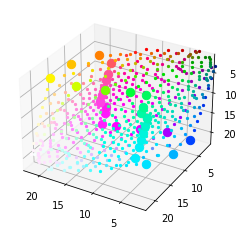

In [56]:
# this plots just the equal theta points
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlim(sum(cmf[:,0]))
ax.set_ylim(sum(cmf[:,1]))
ax.set_zlim(sum(cmf[:,2]))

for o in final_outputs:
    for t in o:
        rgb = clip2rgb((rot.T @ t)/sum(cmf))
        ax.scatter(*(rot.T @ t), color=rgb, s=5)

for s in semi_equal_thetas:
    rgb = clip2rgb(s/sum(cmf))
    ax.scatter(*(s), color=rgb, s=70)

# 6. Map to sphere

In [57]:
final_outputs.shape

(17, 32, 3)

In [58]:
from numpy import cos, sin

In [59]:
def get_sphere_coords(num_axial_pts, num_theta_pts):
    # in polar coordinates
    # phi and theta are given
    phis = np.linspace(0, np.pi, num_axial_pts + 2)[1:-1]
    thetas = np.linspace(0, 2*np.pi, num_theta_pts + 1)[:-1]
    out = np.zeros((len(phis), len(thetas), 3))
    for pidx, p in enumerate(phis):
        for tidx, t in enumerate(thetas):
            out[pidx, tidx, :] = [cos(t)*sin(p), sin(t)*sin(p), cos(p)]
    return out

In [60]:
sphere = get_sphere_coords(final_outputs.shape[0], final_outputs.shape[1])

In [61]:
sphere.shape

(17, 32, 3)

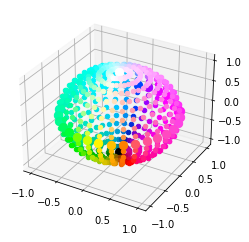

In [62]:
fig = plt.figure()
ax = fig.gca(projection='3d')
for s1, f1 in zip(sphere, final_outputs):
    for s2, f2 in zip(s1, f1):
        rgb = clip2rgb((rot.T @ f2)/sum(cmf))
        ax.scatter(*s2, color=rgb, s=20)
        
for idx, s in enumerate(semi_equal_thetas):
    rgb = clip2rgb(s/sum(cmf))
    ax.scatter(*sphere[NUM_PTS, idx, :], color=rgb, s=70)

ax.scatter(0,0,1,color='white', s=70)
ax.scatter(0,0,-1,color='black', s=70)

# 7. Get a map from point on sphere to given color (or mixture?) -- should include "in between points" on surface and in interior

---

---

# below is NO longer needed

### calculate area of triangles on plane

use $(\rho, y)$ coordinates

calculate area from 

In [63]:
# gray = np.array([0,wt_mag/2,0])

In [64]:
# def rho(v):
#     return (v[0]**2 + v[2]**2)**0.5

In [65]:
# def convert_2d(v):
#     return (rho(v), v[1])

$$
0.5 \Big| A_x (B_y - C_y) + B_x( C_y - A_y) + C_x(A_y - B_y) \Big|
$$

In [66]:
# # sum up areas in plane

# def area(a,b,c):
#     return 0.5*abs( a[0]*(b[1] - c[1]) + b[0]*(c[1] - a[1]) + c[0]*(a[1] - b[1]) )

In [67]:
# slice_areas = []

# for tidx in range(outputs.shape[1]):
#     pts = np.array([[0,0,0]] + list(outputs[:, tidx, :]) + [[0,wt_mag,0]])
#     plane_area = 0
#     for idx, pt in enumerate(pts[:-1]):
#         plane_area += area(*list(map(convert_2d, [pt, pts[idx+1], gray])))
#     slice_areas.append(plane_area)
    
# slice_areas = np.array(slice_areas)
# total_area = sum(slice_areas)

# NUM_WEDGES = 8
# target_area = total_area/NUM_WEDGES

# new_pts = [0]
# new_volumes = []
# i = 0
# while i < len(slice_areas):
#     v = 0
#     while v < target_area and i < len(slice_areas):
#         v += slice_areas[i]
#         i += 1
    
#     new_pts.append(i)
#     new_volumes.append(v)
# new_pts[:-1], new_volumes

In [68]:
# thetas[new_pts[:-1]]

In [69]:
# np.linspace(0, 2*pi, NUM_WEDGES + 1)[:-1]

In [70]:
# equal_cuts = outputs[:, new_pts[:-1], :]